In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tanerzer","key":"6a738120362e1d0ee8a395b5fc9a6333"}'}

In [ ]:
!ls -lha kaggle.json

!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 64 Jun  3 09:30 kaggle.json


In [ ]:
!kaggle datasets download -d abhikjha/utk-face-cropped

 98% 228M/232M [00:03<00:00, 65.2MB/s]
100% 232M/232M [00:03<00:00, 71.0MB/s]


In [ ]:
!ls

drive  kaggle.json  sample_data  utk-face-cropped.zip


In [ ]:
!unzip utk-face-cropped.zip

In [ ]:
!ls

drive  kaggle.json  sample_data  utkcropped  utk-face-cropped.zip


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2

wd = os.getcwd()
path = os.path.join(wd, "utkcropped/utkcropped")
files = os.listdir(path)
size = len(files)
print("Veri sayisi", size)

Veri sayisi 23709


In [ ]:
gender = [i.split('_')[1] for i in files]

In [ ]:
values, counts = np.unique(gender, return_counts=True)
print(counts)

[12391 11318]


In [ ]:
say=0
for i in gender:
   say=say+1
   if i=="3":
     print(say)

In [ ]:
gender[15539]

'1'

In [ ]:
gender[15539]="1"

In [ ]:
classes = []
for i in gender:
    i = int(i)
    classes.append(i)

In [ ]:
from keras.utils.np_utils import to_categorical

In [ ]:
categorical_labels = to_categorical(classes, num_classes=2)
categorical_labels[:5]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
df = pd.DataFrame({"Cinsiyet": gender})

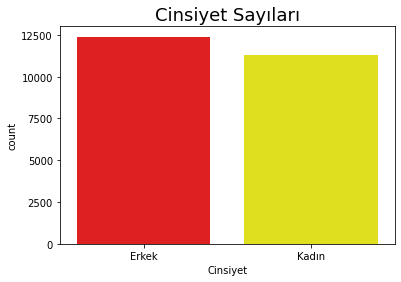

In [ ]:
    fig, ax = plt.subplots()
    sns.set_context("talk")
    sns.set_palette(["red", "yellow"])
    sns.countplot(x="Cinsiyet", data=df, order=["0","1"])
    ax.set_xticklabels(["Erkek", "Kadın"])
    ax.set_title("Cinsiyet Sayıları")
    plt.show()
    fig.savefig('csdagilimi.png', dpi=300, bbox_inches='tight')

In [ ]:
images=[]
i=0
for file in files:
  total=path+'/'+file
  print(total," i:",i)
  i=i+1
  image=cv2.imread(total)

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image= cv2.resize(image,(64,64))
  images.append(image)

In [ ]:
x_data=np.array(images)
x_data.shape

(23709, 64, 64, 3)

In [ ]:
x = np.squeeze(x_data)
x = x.astype('float32')
x /= 255
x.shape

(23709, 64, 64, 3)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_valid, y_train, y_test = train_test_split(x, categorical_labels, test_size=0.2)
X_valid , X_test, y_valid, y_test = train_test_split(X_valid, y_test, test_size=0.5)

In [ ]:
print("X_train", X_train.shape)
print("X_valid", X_valid.shape)
print("X_test", X_test.shape)

X_train (18967, 64, 64, 3)
X_valid (2371, 64, 64, 3)
X_test (2371, 64, 64, 3)


In [ ]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense,Conv2D,Activation,MaxPool2D,Flatten,Dropout,BatchNormalization
from keras.utils import np_utils
from keras_preprocessing import image
from keras.callbacks import ModelCheckpoint

In [ ]:
model= Sequential()

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation("sigmoid")) #sınıflama işlemi 

#optimazyon basarım metrikleri
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

model.summary() #modelin özeti

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0

In [ ]:
root="/gdrive/My Drive/Kaggle/"

In [ ]:
# en başarılı ağırlıkları kaydet
checkpointer = ModelCheckpoint(filepath=root + 'data/gender_face_model.h5', verbose=1, save_best_only=True)

epochs = 50
batchSize = 100 

# modeli çalıştır
hist = model.fit(X_train, y_train, 
                 epochs=epochs,
                 shuffle=True,
                 batch_size=batchSize, 
                 validation_data=(X_valid, y_valid),
                 callbacks=[checkpointer], verbose=2)

# save model to json
model_json = model.to_json()
with open(root + "data/gender_face_model.json", "w") as json_file:
    json_file.write(model_json)

Epoch 1/50
190/190 - 48s - loss: 0.6354 - accuracy: 0.6657 - val_loss: 0.4761 - val_accuracy: 0.7916

Epoch 00001: val_loss improved from inf to 0.47608, saving model to /gdrive/My Drive/Kaggle/data/gender_face_model.h5
Epoch 2/50
190/190 - 4s - loss: 0.4212 - accuracy: 0.8056 - val_loss: 0.3717 - val_accuracy: 0.8372

Epoch 00002: val_loss improved from 0.47608 to 0.37167, saving model to /gdrive/My Drive/Kaggle/data/gender_face_model.h5
Epoch 3/50
190/190 - 4s - loss: 0.3729 - accuracy: 0.8278 - val_loss: 0.3555 - val_accuracy: 0.8499

Epoch 00003: val_loss improved from 0.37167 to 0.35551, saving model to /gdrive/My Drive/Kaggle/data/gender_face_model.h5
Epoch 4/50
190/190 - 4s - loss: 0.3482 - accuracy: 0.8415 - val_loss: 0.3179 - val_accuracy: 0.8633

Epoch 00004: val_loss improved from 0.35551 to 0.31786, saving model to /gdrive/My Drive/Kaggle/data/gender_face_model.h5
Epoch 5/50
190/190 - 4s - loss: 0.3255 - accuracy: 0.8572 - val_loss: 0.3001 - val_accuracy: 0.8701

Epoch 0000

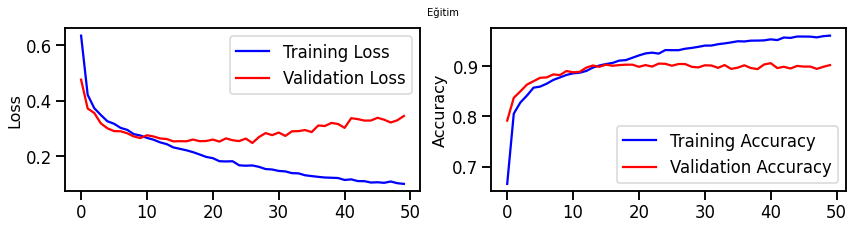

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Eğitim', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()

In [ ]:
loss,acc = model.evaluate(X_test,  y_test, verbose=2)
print("başarım oranı: {:5.2f}%".format(100*acc))

75/75 - 0s - loss: 0.3591 - accuracy: 0.8992
başarım oranı: 89.92%


In [ ]:
labels =["Erkek","Kadin"]
import matplotlib.pyplot as plt

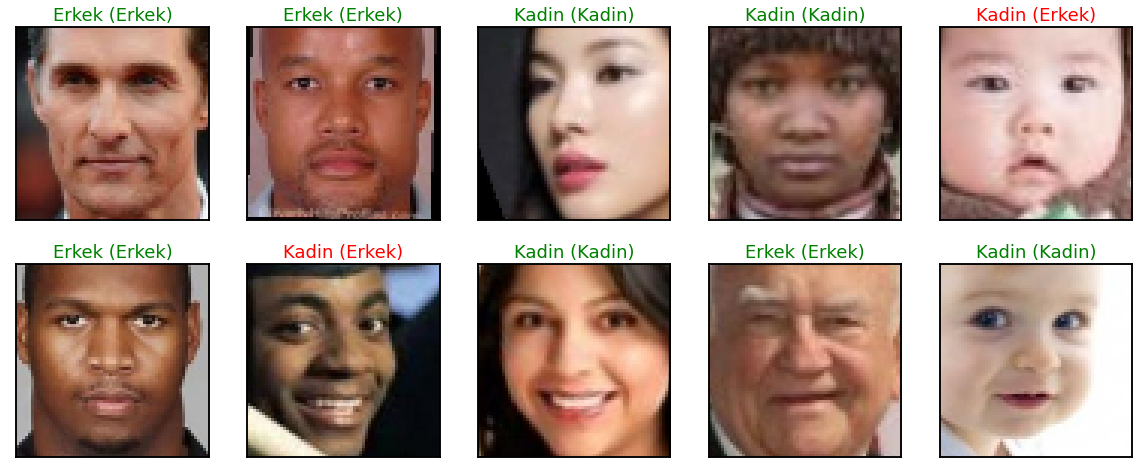

In [ ]:
Y = model.predict(X_test)

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=10, replace=False)):
    ax = figure.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
    
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = np.argmax(Y[index])
    true_index = np.argmax(y_test[index])
    
    ax.set_title("{} ({})".format(labels[predict_index], 
                                  labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))
plt.show()

In [ ]:
import json
from keras.models import load_model
from keras.models import model_from_json
from keras.preprocessing import image

model_json = model.to_json()
with open("gender2.json",'w') as json_file:
  json_file.write(model_json)

model.save('gender2.h5')